<a href="https://colab.research.google.com/github/Hrishkesh/Invoice-/blob/master/Data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Hrishkesh/Invoice-.git

Cloning into 'Invoice-'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 129 (delta 71), reused 49 (delta 19), pack-reused 0
Receiving objects: 100% (129/129), 4.12 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
!ls Invoice-/

Data_visualization.ipynb  network.py		preprocessing_ter.py
example.png		  preprocessing_bis.py	README.md
Invoice_new.ipynb	  preprocessing.py


In [4]:
import os
from getpass import getpass
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password
os.environ['GITHUB_USER'] = user
os.environ['GITHUB_PASSWORD'] = user

GitHub user··········
GitHub password··········


In [5]:
!git config --global user.email "hrishkesh.pattepu@gmail.com"
!git config --global user.name "Hrishkesh"

In [6]:
!cd Invoice- && git remote set-url origin https://$GITHUB_AUTH@github.com/$GITHUB_USER/Invoice-.git

In [7]:
!cd Invoice- && git pull

Already up to date.


In [8]:
!cd Invoice- && git add .

In [9]:
!cd Invoice- && git commit -m "training"

On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


In [10]:
!cd Invoice- && git push

Everything up-to-date


In [11]:
!pip install colab_ssh --upgrade

In [12]:
from colab_ssh import launch_ssh, init_git
from getpass import getpass
ngrokToken = '1cfbiKCtHgohcxmNMIXe34CpbET_7GibpvfZdp55n7ordbjoT'
#password = getpass('Password of your choice')
password = 'root'
launch_ssh(ngrokToken,password)

Successfully running 2.tcp.ngrok.io:11025
[Optional] You can also connect with VSCode SSH Remote extension using this configuration:

	Host google_colab_ssh
		HostName 2.tcp.ngrok.io
		User root
		Port 11025
	  


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!apt install tesseract-ocr -q
!pip install pytesseract

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 59 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,777 kB/s)
Selecting previously unselected package tes

In [22]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pytesseract as te
import os
import re
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
!ls /content/drive

'My Drive'


In [29]:
!unzip /content/drive/My\ Drive/invoice_eng/input/Data_Folder.zip -d /content/drive/My\ Drive/

Archive:  /content/drive/My Drive/invoice_eng/input/Data_Folder.zip
mapname:  conversion of  failed
   creating: /content/drive/My Drive/dir_img/
   creating: /content/drive/My Drive/dir_boxes/
   creating: /content/drive/My Drive/dir_classes/
 extracting: /content/drive/My Drive/dir_img/X51005605333.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005719862.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005757353.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005711454.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005745214.jpg  
 extracting: /content/drive/My Drive/dir_img/X51006557188.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005712038.jpg  
 extracting: /content/drive/My Drive/dir_img/X51007103643.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005806685.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005757304.jpg  
 extracting: /content/drive/My Drive/dir_img/X51005433514.jpg  
 extracting: /content/drive/My Drive/dir_img/X510060

In [196]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [197]:
!ls /content/drive/My\ Drive

dir_boxes  dir_classes	dir_img  invoice_eng


In [198]:
## Hyperparameters
dir_img = "/content/drive/My Drive/dir_img"
dir_boxes = "/content/drive/My Drive/dir_boxes"
dir_classes = "/content/drive/My Drive/dir_classes"
outdir_np_chargrid = "./data/np_chargrids/"
outdir_png_chargrid = "./data/img_chargrids/"
outdir_np_gt = "./data/np_gt/"
outdir_png_gt = "./data/img_gt/"
outdir_pd_bbox = "./data/pd_bbox/"
tesseract_conf_threshold = 10
cosine_similarity_threshold = 0.4
list_classes = ["company", "date", "address", "total"]
nb_classes = len(list_classes)

In [199]:
list_filenames = [f for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f)) and os.path.isfile(os.path.join(dir_boxes, f).replace("jpg", "txt")) and os.path.isfile(os.path.join(dir_classes, f).replace("jpg", "txt"))]
len(list_filenames)

618

In [200]:
def extract_tesseract_information(filename):
    img = plt.imread(os.path.join(dir_img, filename), format='jpeg')
    print(filename, img.shape)
    
    dt = te.image_to_data(img, config="", output_type=te.Output.DATAFRAME, pandas_config=None)
    dt = dt[dt['conf']>tesseract_conf_threshold]
    dt["text"] = dt["text"].astype('str')
    
    return dt, img.shape

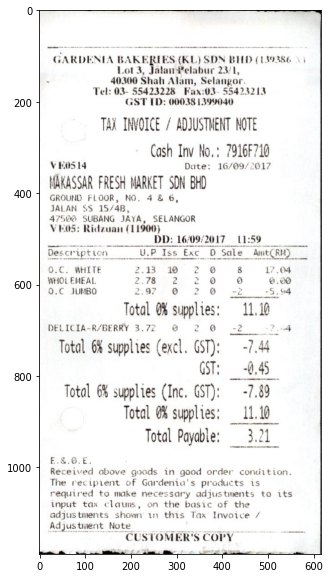

In [237]:
import random
index = random.randint(0,len(list_filenames))
filename = list_filenames[index]
img = np.array(Image.open('/content/drive/My Drive/dir_img/' + filename), dtype=np.uint8)
#img = mpimg.imread('/content/drive/My Drive/dir_img/' + filename)
fig = plt.figure(figsize=(10,10))
plt.imshow(img)

# Extract tesseract dataframe (Bounding box for each word)

In [238]:
dt, img_shape = extract_tesseract_information(filename)
print(img_shape)

X51006556841.jpg (1190, 616, 3)
(1190, 616, 3)


In [239]:
dt

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,32,81,111,36,49,GARDENI
5,5,1,1,1,1,2,148,100,14,16,94,A
6,5,1,1,1,1,3,172,81,67,36,87,BAKE
7,5,1,1,1,1,4,258,100,39,17,84,TES
8,5,1,1,1,1,5,305,100,48,20,71,(KL)
...,...,...,...,...,...,...,...,...,...,...,...,...
241,5,1,18,1,8,2,358,1141,66,21,96,COPY
245,5,1,19,1,1,1,0,1182,136,8,42,eee
246,5,1,19,1,1,2,137,1180,160,10,28,ee
250,5,1,19,1,1,6,474,1185,106,5,26,et


# Bounding box to each letter from output of tesseract : chargrid_pd

In [240]:
def get_chargrid(dt):
    chargrid_pd = pd.DataFrame(columns = ['left', 'top', 'width', 'height', 'ord', 'conf'])

    for index, row in dt.iterrows():
        for i in range(0, len(row["text"])):
            row['width'] = (row['width']+len(row["text"])-1)//len(row["text"])*len(row["text"]) # Split character by character
        
            chargrid_pd = chargrid_pd.append({
            'left':row['left']+row['width']*i//len(row["text"]),
            'top':row['top'],
            'width':row['width']//len(row["text"]),
            'height':row['height'],
            'ord':ord(row["text"][i]),
            'conf':row["conf"]
            }, ignore_index = True)

    chargrid_pd = chargrid_pd[chargrid_pd['ord']>=33]
    chargrid_pd = chargrid_pd[chargrid_pd['ord']<=126]
    chargrid_pd['ord'] -= 32
    
    return chargrid_pd

In [241]:
chargrid_pd = get_chargrid(dt)

In [242]:
chargrid_pd

,left,top,width,height,ord,conf
0,32,81,16,36,39,49
1,48,81,16,36,33,49
2,64,81,16,36,50,49
3,80,81,16,36,36,49
4,96,81,16,36,37,49
...,...,...,...,...,...,...
715,92,1182,46,8,69,42
716,137,1180,80,10,69,28
717,217,1180,80,10,69,28
718,474,1185,53,5,69,26


# Draw bounding boxes on group of words using dir_boxes ground truth txt files

In [243]:
def add_row_gt_pd(row, c, gt_pd):
    return gt_pd.append({
            'left':row['top_left_x'],
            'top':row['top_left_y'],
            'right':row['bot_right_x'],
            'bot':row['bot_right_y'],
            'class':c
            }, ignore_index = True)

In [244]:
def extract_class_bounding_boxes(filename):
    gt_pd = pd.DataFrame(columns = ['left', 'top', 'right', 'bot', 'class'])
    
    ## Import ground truth files
    pd_boxes = pd.DataFrame(columns=['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y', 'bot_left_x', 'bot_left_y', 'bot_right_x', 'bot_right_y', 'text'])
    dic_class = dict()
    
    with open(os.path.join(dir_boxes, filename).replace("jpg", "txt")) as f:
        reader = f.read().splitlines()
        pd_boxes = pd.DataFrame([x.split(",", 8) for x in reader], columns=['top_left_x', 'top_left_y', 'top_right_x', 'top_right_y', 'bot_right_x', 'bot_right_y', 'bot_left_x', 'bot_left_y', 'text'])
    
        pd_boxes["top_left_x"] = pd_boxes["top_left_x"].astype('int')
        pd_boxes["top_left_y"] = pd_boxes["top_left_y"].astype('int')
        pd_boxes["top_right_x"] = pd_boxes["top_right_x"].astype('int')
        pd_boxes["top_right_y"] = pd_boxes["top_right_y"].astype('int')
        pd_boxes["bot_left_x"] = pd_boxes["bot_left_x"].astype('int')
        pd_boxes["bot_left_y"] = pd_boxes["bot_left_y"].astype('int')
        pd_boxes["bot_right_x"] = pd_boxes["bot_right_x"].astype('int')
        pd_boxes["bot_right_y"] = pd_boxes["bot_right_y"].astype('int')
        pd_boxes["text"] = pd_boxes["text"].str.upper()

        fig,ax = plt.subplots(1, figsize=(10,10))
        ax.imshow(img)
        for i in range(len(pd_boxes)):
          rect = patches.Rectangle((pd_boxes['bot_left_x'][i],pd_boxes['bot_left_y'][i]),
                             (pd_boxes['top_right_x'][i]-pd_boxes['top_left_x'][i]),
                             (pd_boxes['top_left_y'][i]-pd_boxes['bot_left_y'][i]),
                             linewidth=1,edgecolor='r',facecolor='none')
          ax.add_patch(rect)
        plt.show()
  
        
    
    with open(os.path.join(dir_classes, filename).replace("jpg", "txt")) as f:
        dic_class = json.load(f)
    for i in range(nb_classes):
        if list_classes[i] not in dic_class.keys():
            dic_class[list_classes[i]] = "UNKNOWN"
        dic_class[list_classes[i]] = dic_class[list_classes[i]].upper()
    
    ## Detect classes in the bounding box file
    vectorized_text = CountVectorizer().fit_transform([dic_class[list_classes[i]] for i in range(nb_classes)]+pd_boxes["text"].tolist())
    
    for index, row in pd_boxes.iterrows():
        #Classes of type string
        if cosine_similarity(vectorized_text[0].reshape(1, -1), vectorized_text[index+nb_classes].reshape(1, -1))[0][0] > cosine_similarity_threshold:
            gt_pd = add_row_gt_pd(row, 3, gt_pd)
        
        if cosine_similarity(vectorized_text[2].reshape(1, -1), vectorized_text[index+nb_classes].reshape(1, -1))[0][0] > cosine_similarity_threshold:
            gt_pd = add_row_gt_pd(row, 2, gt_pd)
        
        #Classes of type date
        tab_date = re.findall(r'((?i)(?:[12][0-9]|3[01]|0*[1-9])(?P<sep>[- \/.\\])(?P=sep)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep)+(?:19|20)\d\d|(?:[12][0-9]|3[01]|0*[1-9])(?P<sep2>[- \/.\\])(?P=sep2)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep2)+\d\d|(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P<sep3>[- \/.\\])(?P=sep3)*(?:[12][0-9]|3[01]|0*[1-9])(?P=sep3)+(?:19|20)\d\d|(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P<sep4>[- \/.\\])(?P=sep4)*(?:[12][0-9]|3[01]|0*[1-9])(?P=sep4)+\d\d|(?:19|20)\d\d(?P<sep5>[- \/.\\])(?P=sep5)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep5)+(?:[12][0-9]|3[01]|0*[1-9])|\d\d(?P<sep6>[- \/.\\])(?P=sep6)*(?:1[012]|0*[1-9]|jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?P=sep6)+(?:[12][0-9]|3[01]|0*[1-9])|(?:[12][0-9]|3[01]|0*[1-9])(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:19|20)\d\d|(?:[12][0-9]|3[01]|0*[1-9])(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\d\d|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])(?:19|20)\d\d|(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])\d\d|(?:19|20)\d\d(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])|\d\d(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)(?:[12][0-9]|3[01]|0*[1-9])|(?:[12][0-9]|3[01]|0[1-9])(?:1[012]|0[1-9])(?:19|20)\d\d|(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])(?:19|20)\d\d|(?:19|20)\d\d(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])|(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9])\d\d|(?:[12][0-9]|3[01]|0[1-9])(?:1[012]|0[1-9])\d\d|\d\d(?:1[012]|0[1-9])(?:[12][0-9]|3[01]|0[1-9]))', row["text"])
        for dat in tab_date:
            if dat[0] == dic_class["date"]:
                gt_pd = add_row_gt_pd(row, 4, gt_pd)
        
        #Classes of type float
        tab_floats = re.findall(r'([-+]?[0-9]*\.?[0-9]+)', row["text"])
        total_float = re.search(r'([-+]?[0-9]*\.?[0-9]+)', dic_class["total"])
        if total_float:
            for flo in tab_floats:
                if float(total_float.group(0)) == float(flo):
                    gt_pd = add_row_gt_pd(row, 1, gt_pd)
    
    return gt_pd

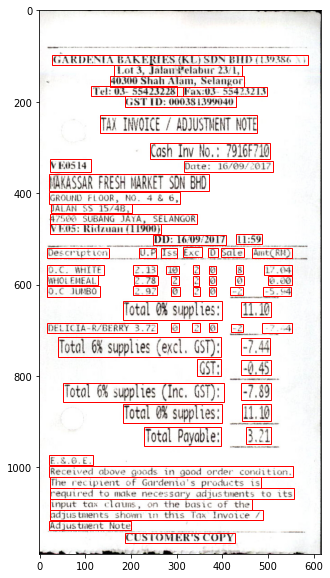

In [245]:
gt_pd = extract_class_bounding_boxes(filename)

In [246]:
pd_boxes.head()

,top_left_x,top_left_y,top_right_x,top_right_y,bot_right_x,bot_right_y,bot_left_x,bot_left_y,text
0,151,93,574,93,574,142,151,142,POPULAR BOOK
1,114,150,644,150,644,208,114,208,CO. (M) SDN BHD
2,202,214,518,214,518,245,202,245,(CO. NO. 113825-W)
3,131,253,590,253,590,285,131,285,(GST REG NO. 001492992000)
4,54,291,663,291,663,323,54,323,"NO 8, JALAN 7/118B, DESA TUN RAZAK"


In [247]:
gt_pd

,left,top,right,bot,class
0,27,97,587,120,3
1,163,120,444,143,2
2,154,144,448,167,2
3,316,330,511,353,4
4,248,491,408,513,4
5,452,913,506,949,1


# Draw bounding boxes based on classes

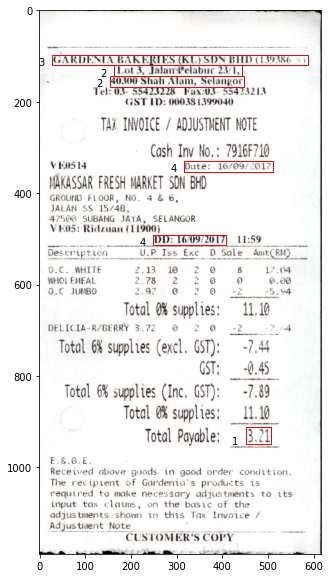

In [248]:
fig,ax = plt.subplots(1,figsize=(10,10))
ax.imshow(img)
for i in range(len(gt_pd)):
  rect1 = patches.Rectangle((gt_pd['left'][i],gt_pd['top'][i]),
                            (gt_pd['right'][i]-gt_pd['left'][i]),
                            (gt_pd['bot'][i]-gt_pd['top'][i]),
                            linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect1)
  ax.text(gt_pd['left'][i]-30,gt_pd['bot'][i],gt_pd['class'][i])  
plt.show()

In [249]:
chargrid_pd.head()

,left,top,width,height,ord,conf
0,32,81,16,36,39,49
1,48,81,16,36,33,49
2,64,81,16,36,50,49
3,80,81,16,36,36,49
4,96,81,16,36,37,49


In [250]:
gt_pd.head()

,left,top,right,bot,class
0,27,97,587,120,3
1,163,120,444,143,2
2,154,144,448,167,2
3,316,330,511,353,4
4,248,491,408,513,4


In [251]:
img_shape

(1190, 616, 3)

In [252]:
np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1])).shape

(1190, 616)

# Replace each pixel in input image by ASCII value --> chargrid_np
# Replace each pixel in output image by class number --> gt_np

In [253]:
def get_reduced_output(chargrid_pd, gt_pd, img_shape):

    # Add plots
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(img)
    ax[1].imshow(img)
    for i in range(len(gt_pd)):
      rect1 = patches.Rectangle((gt_pd['left'][i],gt_pd['top'][i]),
                          (gt_pd['right'][i]-gt_pd['left'][i]),
                          (gt_pd['bot'][i]-gt_pd['top'][i]),
                          linewidth=1,edgecolor='r',facecolor='none')
      ax[1].add_patch(rect1)
      ax[1].text(gt_pd['left'][i]-30,gt_pd['bot'][i],gt_pd['class'][i])  

    chargrid_np = np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1]))
    
    chargrid_pd.sort_values(by="conf", ascending=True, inplace=True) #Sort by confidence
    chargrid_pd.reset_index(drop=True, inplace=True)
    
    for index, row in chargrid_pd.iterrows():
        chargrid_np[row['top']:row['top']+row['height'], row['left']:row['left']+row['width']] = row['ord']
    
    gt_np = np.array([0]*img_shape[0]*img_shape[1]).reshape((img_shape[0], img_shape[1]))
    
    gt_pd.sort_values(by="class", ascending=True, inplace=True) #Sort by confidence
    gt_pd.reset_index(drop=True, inplace=True)
    
    for index, row in gt_pd.iterrows():
        gt_np[row['top']:row['bot'], row['left']:row['right']] = row['class']
 
    ax[2].imshow(chargrid_np)
    ax[3].imshow(gt_np)
    
    ## Remove empty rows and columns
    tab_cumsum_todelete_x = np.cumsum(np.all(chargrid_np == 0, axis=0))
    gt_pd['left'] -= tab_cumsum_todelete_x[gt_pd['left'].tolist()]
    gt_pd['right'] -= tab_cumsum_todelete_x[gt_pd['right'].tolist()]
    
    tab_cumsum_todelete_y = np.cumsum(np.all(chargrid_np == 0, axis=1))
    gt_pd['top'] -= tab_cumsum_todelete_y[gt_pd['top'].tolist()]
    gt_pd['bot'] -= tab_cumsum_todelete_y[gt_pd['bot'].tolist()]
    
    gt_np = gt_np[:,~np.all(chargrid_np == 0, axis=0)]
    gt_np = gt_np[~np.all(chargrid_np == 0, axis=1),:]
    
    chargrid_np = chargrid_np[:,~np.all(chargrid_np == 0, axis=0)]
    chargrid_np = chargrid_np[~np.all(chargrid_np == 0, axis=1),:]

    img_cropped = img[:,~np.all(chargrid_np == 0, axis=0)]

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(img_cropped)

    ax[1].imshow(chargrid_np)
    ax[2].imshow(gt_np)
    
    return chargrid_np, gt_np, gt_pd

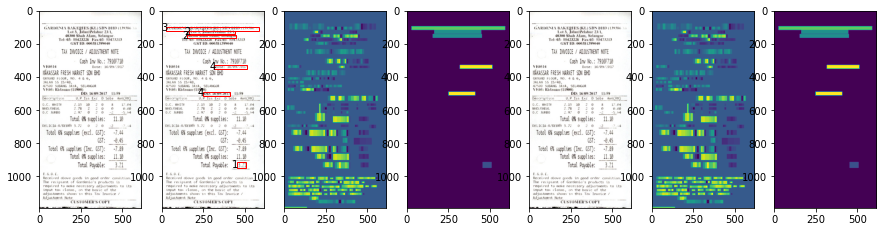

In [254]:
chargrid_np, gt_np, gt_pd = get_reduced_output(chargrid_pd, gt_pd, img_shape)

# Class Mapping

- 0 : Other
- 1 : Total 
- 2 : Address 
- 3 : Company name 
- 4 : Date 

In [91]:
chargrid_np.shape

(884, 668)

In [92]:
gt_np.shape

(884, 668)

In [ ]:
if __name__ == "__main__":
    list_filenames = [f for f in os.listdir(dir_img) if os.path.isfile(os.path.join(dir_img, f)) and os.path.isfile(os.path.join(dir_boxes, f).replace("jpg", "txt")) and os.path.isfile(os.path.join(dir_classes, f).replace("jpg", "txt"))]
    
    print("Number of input files : ", len(list_filenames))
    i = 0
    for filename in list_filenames:
        dt, img_shape = extract_tesseract_information(filename)
        
        chargrid_pd = get_chargrid(dt)
        
        gt_pd = extract_class_bounding_boxes(filename)
        
        chargrid_np, gt_np, gt_pd = get_reduced_output(chargrid_pd, gt_pd, img_shape)
        if i==0:
            gt_pd_full = gt_pd
        else:
            gt_pd_full = gt_pd_full.append(gt_pd)
        
       
        i+=1
         #print(gt_pd)
        #plot_input_vs_output(chargrid_np, gt_np)
    print(gt_pd_full)

Number of input files :  618
X51005711404.jpg (1780, 932, 3)
X51005711447.jpg (1692, 932, 3)
X51006414733.jpg (6981, 4945, 3)
X51005711451.jpg (1695, 932, 3)
X51006912960.jpg (6712, 4854, 3)
X51005711445.jpg (1783, 932, 3)
X51005711453.jpg (1757, 920, 3)
X51005711452.jpg (1929, 920, 3)
X51005712021.jpg (1072, 584, 3)
X51005712017.jpg (1214, 608, 3)
X51005712038.jpg (1192, 616, 3)
X51005711456.jpg (2779, 936, 3)
X51005711454.jpg (2283, 936, 3)
X51006912972.jpg (7016, 4961, 3)
X51005715451.jpg (1491, 615, 3)
X51006912974.jpg (7016, 4961, 3)
X51006913007.jpg (7016, 4961, 3)
X51005715010.jpg (1727, 615, 3)
X51005717526.jpg (1312, 600, 3)
X51005712039.jpg (1182, 616, 3)
X51005715456.jpg (1295, 607, 3)
X51005719856.jpg (2222, 932, 3)
X51005719862.jpg (1424, 884, 3)
X51005719814.jpg (1617, 936, 3)
X51005719873.jpg (2852, 932, 3)
X51006913019.jpg (7016, 4961, 3)
X51005719864.jpg (1741, 884, 3)
X51006913023.jpg (7016, 4961, 3)
X51005719893.jpg (2017, 936, 3)
X51005719874.jpg (1368, 932, 3)
X510

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: Flags not at the start of the expression '((?i)(?:[12][0-9]|3[' (truncated)


X51005757324.jpg (1330, 708, 3)
X51005757294.jpg (1227, 710, 3)
X51005757323.jpg (1451, 710, 3)
X51005757346.jpg (1302, 708, 3)
X51007846269.jpg (7016, 4961, 3)
X51005757304.jpg (1784, 703, 3)
X51007846270.jpg (7016, 4961, 3)
X51007846286.jpg (7016, 4961, 3)
X51005806716.jpg (1290, 770, 3)
X51005806703.jpg (1617, 864, 3)
X51005806702.jpg (1424, 841, 3)
X51005806685.jpg (1180, 747, 3)
X51005806698.jpg (1246, 687, 3)
X51005757349.jpg (1373, 703, 3)
X51007846301.jpg (7016, 4961, 3)
X51005757351.jpg (1328, 703, 3)
X51005763940.jpg (1946, 740, 3)
X51005757353.jpg (1448, 698, 3)
X51007846302.jpg (7016, 4961, 3)
X51005889296.jpg (1331, 619, 3)
X51006008057.jpg (2007, 724, 3)
X51006008074.jpg (1457, 748, 3)
X51007846305.jpg (7016, 4961, 3)
X51006008073.jpg (1337, 813, 3)
X51006008086.jpg (1863, 754, 3)
X51007846307.jpg (7016, 4961, 3)
X51006008197.jpg (768, 746, 3)
X51006311758.jpg (2153, 949, 3)
X51006008089.jpg (2177, 744, 3)
X51007846309.jpg (7016, 4961, 3)
X51006008091.jpg (1824, 746, 3)
X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: Flags not at the start of the expression '((?i)(?:[12][0-9]|3[' (truncated)


X51006414712.jpg (7016, 4961, 3)
X51005676549.jpg (1973, 932, 3)
X51005676547.jpg (1864, 932, 3)
X51005677328.jpg (1865, 935, 3)
X51006414713.jpg (7016, 4961, 3)
X51005677329.jpg (1864, 938, 3)
X51006414714.jpg (7016, 4961, 3)
X51005677339.jpg (1927, 934, 3)
X51005677335.jpg (1972, 938, 3)
X51005677331.jpg (2081, 934, 3)
X51006414718.jpg (7016, 4961, 3)
X51005677334.jpg (1975, 932, 3)
X51005677332.jpg (1859, 935, 3)
X51006414719.jpg (7016, 4961, 3)
X51005685357.jpg (1535, 623, 3)
X51005685355.jpg (1403, 615, 3)
X51005705804.jpg (2143, 1263, 3)
X51005705722.jpg (1816, 958, 3)
X51006414720.jpg (6724, 4854, 3)
X51005711442.jpg (1869, 932, 3)
X51005711441.jpg (1784, 932, 3)
X51005711401.jpg (1907, 932, 3)
X51005711403.jpg (1865, 932, 3)
X51006414721.jpg (7016, 4961, 3)
    left  top right  bot class
0    629  595   706  631     1
1    564  631   705  666     1
2    631  666   705  700     1
3    108   64   605  104     2
4     66  104   657  142     2
..   ...  ...   ...  ...   ...
2    17

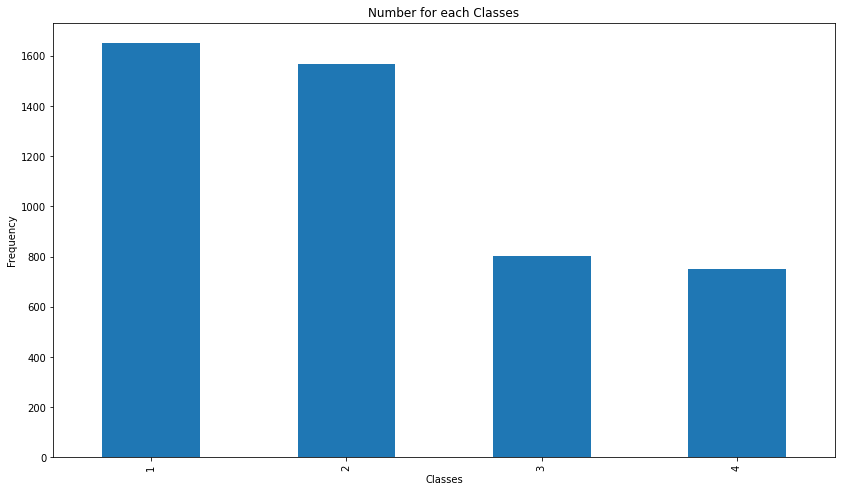

In [ ]:
ax = gt_pd_full['class'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
plt.show()